# Modelación de flujo de agua subterránea en un medio heterogéneo/Perfil

* Autor: Ricardo Balam Chagoya Morales


### Modelo conceptual

la vista en perfil nos permite tener una visión más clara del
movimiento del flujo en el subsuelo, y en conjunto con la vista en planta, nos ayuda a tener
un mejor panorama de la dirección y sentido del flujo. La simulación de la vista en perfil
tendrá las mismas características que la homogénea, solo que en esta ocasión en el modelo
teórico-conceptual los subdominios con diferente condutividad se encuentran a profundidad,
en este caso representan dos estratos con diferente conductividad hidráulica que corresponden
a un sedimento de grano fino y un sedimento de grano grueso. La delimitación de las condiciones de frontera; las fronteras laterales y la frontera inferior se supondran barreras impermeables, mientras que la frontera superior se expresa como una función lineal donde la carga hidráulica varia en su valor máximo (100 m) hasta su valor minimo (10 m).

<img src="../Tesis/Figura_27.png" alt="Figura_27.png" width="400"/>

### Modelo matemático

La ecuación que representa la conductividad hidráulica es:

$$ \dfrac{\partial^{2}h}{\partial{x^{2}}}+\dfrac{\partial{^{2}h}}{\partial{z^{2}}}=0$$

Donde los subdominios ${\Omega}_{1}$ y ${\Omega}_{2}$ son los siguientes:

 $$ {\Omega}_{1}=[0,200]{\times}[0,100] \:\:  Subdominio \: 1 $$
 $$ {\Omega}_{2}=[0,200]{\times}[100,200] \:\: Subdominio \: 2 $$

La formulación integral de la ecuación de flujo se realiza a partir del método variacional, donde $v$ es nuestra función test correspondiente a nuestros espacio de Hilbert $H^{1}$, relajando las condiciones de derivabilidad al momento de multiplicar por nuestra función test y luego integrar, obtenemos la siguiente formulación integral expresada en su forma lineal y bilineal.

 $$a(h,v)=\int_{\Omega}^{} {\nabla}h{\cdot}{\nabla}v \cdot ds$$


 $$L(v)= \int_{\Omega}^{} fv \cdot ds + \int_{{\partial}_{N}}^{} {\nabla}h{\cdot}\textbf{n} \cdot ds$$


La segunda expresión de la ecuación son las condiciones naturales del problema variacional, asumiendo que no existe flujo en las fronteras laterales e inferior, este término se anula, además, el análisis de la porción del acuífero no contempla ningún tipo de fuentes o sumideros, por lo que la función $f$ es igual $0$, por lo que forma lineal queda $L(v)=0$.


In [43]:
from __future__ import print_function
from fenics import *
import numpy as np
import random as ra
import sys
import matplotlib.pyplot as plt

In [53]:
# Se definen los parámetros de la simulación

k1 = 10 #Conductividad hidráulica en la capa inferior
k2 = 100 # Conductividad hidráulica en la capa superior 
lonx = 200 # Longitud en dirección x
lony = 100 # Longirud en dirección y
delta = 10 # Refinación de malla
elemx = int(lonx/delta) # Número de elementos en x
elemy = int(lony/delta) # Número de elementos en y

# Se genera la malla
mesh= RectangleMesh(Point(0,0),Point(lonx,lony),elemx,elemy)
V = FunctionSpace(mesh, 'P', 1)

In [54]:
# Se definen las condiciones de fronteras

u_S = Expression('100-0.45*x[0]', degree=1)

def frontera_S(x,frontera):
 tol=1E-14 
 if frontera:
  if abs(x[1]-100)<=tol: 
   return True
  else:
   return False 
 else:
  return False  


F_S = DirichletBC(V,u_S, frontera_S)
bc = [F_S]

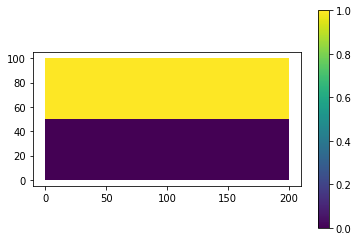

In [55]:
# Se define la heterogeneidad

class K(UserExpression):
 def set_k_values(self, k_0, k_1):
     self.k_0, self.k_1 = k_0, k_1
 def eval(self, value, x):
   tol = 1E-14 
   if  x[1] <= 50 + tol:
      value[0] = self.k_0
   else:
      value[0] = self.k_1

#kappa = K(degree=1)
#kappa.set_k_values(100,10)

# Otra forma de definir la heterogeneidad

class Omega0(SubDomain):
    def inside(self,x,on_boundary):
        return True if x[1] <= 50 else False
    
class Omega1(SubDomain):
    def inside(self,x,on_boundary):
        return True if x[1] >= 50 else False
    
subdomains = MeshFunction("size_t",mesh,2)
subdomain0 = Omega0()
subdomain0.mark(subdomains,0)
subdomain1 = Omega1()
subdomain1.mark(subdomains, 1)

plt.figure()
imgk = plot(subdomains)
plt.colorbar(imgk)

V0 = FunctionSpace(mesh, "DG", 0)
kappa = Function(V0)

k_values = [k1, k2] 
for cell_no in range(len(subdomains.array())):
  subdomain_no = subdomains.array()[cell_no]
  kappa.vector()[cell_no] = k_values[subdomain_no]


In [56]:
#Se define el problema variacional

u=TrialFunction(V)
v=TestFunction(V)
f=Constant(0)
a=kappa*dot(grad(u),grad(v))*dx
g=Constant(0)
L=f*v*dx-g*v*ds

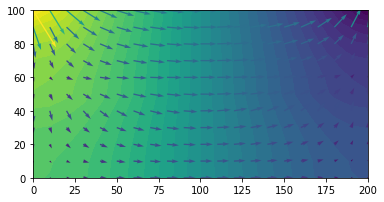

In [57]:
# Se realiza el calculo de la solucion

u= Function(V)
solve(a==L,u,bc)
plot(u)
plot(-grad(u))

In [58]:
# Se organizan los valores para la exportación de los datos

tau=project(grad(u))
xx=np.loadtxt("Coordenadascentroide.csv",delimiter=',',skiprows=1,usecols=[1])
yy=np.loadtxt("Coordenadascentroide.csv",delimiter=',',skiprows=1,usecols=[2])
datos=np.zeros((400,7))
datos[:,0]=xx
datos[:,1]=yy

for i in range(0,399):
 datos[i,2]=tau(xx[i],yy[i])[0]
 datos[i,3]=tau(xx[i],yy[i])[1]

for i in range (0,399): 
 if (datos[i,1]<50):
  datos[i,4]= k1
 else:
  datos[i,4]= k2


In [59]:
#Se exportan los datos de la carga hidráulica

carga=np.zeros([101,201])
for i in range (0,201):
 for j in range (0,101):
    carga[j,i]=u(i,j)

np.savetxt("carga1.2",carga)


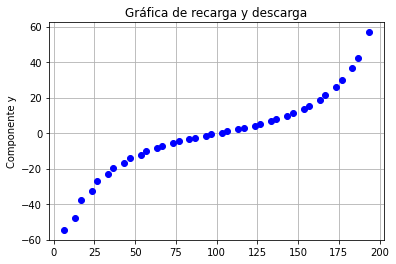

In [60]:
# Se aplica la ecuación de Darcy para obtener el flujo q=k*grad(u); donde k=datos[:,4] y grad(u)=(datos[:,2] y datos[:,3])

for cell_no in range(len(subdomains.array())):
  subdomain_no = subdomains.array()[cell_no]
  datos[cell_no,5] = -k_values[subdomain_no]*datos[cell_no,2]
  datos[cell_no,6] = -k_values[subdomain_no]*datos[cell_no,3]
  

np.savetxt("SoluciónFlujo3.4",datos)


plt.figure()
plt.plot(datos[361:399,0],datos[361:399,6],'bo')
plt.title('Gráfica de recarga y descarga')
plt.ylabel('Componente y')
plt.grid()

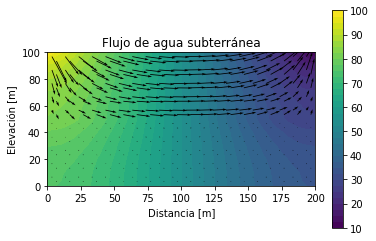

In [61]:
# Ploteo de la solucion
plt.figure()
carga=plot(u)
#plot(-grad(u))
flujo=plt.quiver(xx,yy,datos[:,5],datos[:,6])
plt.colorbar(carga)
plt.title('Flujo de agua subterránea')
plt.ylabel('Elevación [m]')
#plt.colorbar(im)
#plot(mesh)
plt.title('Flujo de agua subterránea')
plt.ylabel('Elevación [m]')
plt.xlabel('Distancia [m]')
plt.show()